In [1]:
import pandas as pd 
import os 
import numpy as np 
import scipy.signal as sig
from raw_pose_analysis_funs.gait_metric_support import (support_interp, support_filter_lowpass,id_toe_off_heel_strike)

In [2]:
# test double support 
## NOTE!! assumes person starts walking away from the camera. Will not be correct if they start walking towards camera !!! 

# load yolo data 
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_hc_outputs\MM_HC\2024-07-30\001_merge_mp_yolo_dfs\MM_HC_17ft_gait_vertical_right_MM_HC_2024-07-30_yolo.csv'
yolo_df = pd.read_csv(yolo_path)

# ground truth file name 
current_filename = 'MM_HC_17ft_gait_vertical_right'
video_id_date_name = current_filename

# fpts
fps = 30 

In [3]:
dir_out_prefix = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_double_support_code'
max_gap = 0.12 # max gap to interpolate over 
cutoff = 0.4
order = 1


In [4]:
# ground truth anotation of turn start and stop time 
# watch videos frame by frame: e on keyboard = move forward one frame 
ground_truth_support_path = r'C:\Users\mmccu\Box\Brainwalk\Home Video Walking\Megan Project\bw_data_and_code\gait\gait_hc_videos\visual_annotation_ground_truth\vertical_double_support_frames.xlsx'
ground_truth_support_df = pd.read_excel(ground_truth_support_path, sheet_name = 'Sheet1', engine='openpyxl')
ground_truth_support_df

,filename,subjectID,task,walk_direction_num,fps,r_heel_strike_frames,QA_seconds,frames between r heel strike and l toe off,l_toe_off_frames,frames between l toe off and l heel strike,l_heel_strike_frames,frames between l heel strike and r toe off,r_toe_off_frames,frames between r toe off and r heel strike
0,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,60,1.000000,13.0,73.0,22.0,95.0,9.0,104.0,24.0
1,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,128,2.133333,10.0,138.0,22.0,160.0,10.0,170.0,23.0
2,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,193,3.216667,9.0,202.0,23.0,225.0,7.0,232.0,24.0
3,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,256,4.266667,8.0,264.0,22.0,286.0,11.0,297.0,23.0
4,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,394,6.566667,9.0,403.0,28.0,431.0,7.0,438.0,25.0
5,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,463,7.716667,9.0,472.0,23.0,495.0,9.0,504.0,25.0
6,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,529,8.816667,10.0,539.0,24.0,563.0,10.0,573.0,24.0
7,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,597,9.950000,8.0,605.0,26.0,631.0,12.0,643.0,NaN
8,DS_HC_gait_vertical_right,DS_HC,gait_vertical_right,away_1,60,54,0.900000,10.0,64.0,29.0,93.0,10.0,103.0,25.0
9,DS_HC_gait_vertical_right,DS_HC,gait_vertical_right,away_1,60,128,2.133333,8.0,136.0,25.0,161.0,10.0,171.0,24.0


In [5]:
# select ground truth data 
ground_truth_support_current = ground_truth_support_df.loc[ground_truth_support_df['filename'] == current_filename]

r_heel_strike_frames = ground_truth_support_current['r_heel_strike_frames']
l_toe_off_frames = ground_truth_support_current['l_toe_off_frames'] 
l_heel_strike_frames = ground_truth_support_current['l_heel_strike_frames'] 
r_toe_off_frames = ground_truth_support_current['r_toe_off_frames'] 


In [6]:
import scipy.signal as sig 

# interpolate 
yolo_support_interp_dfs = support_interp(yolo_df, video_id_date_name, dir_out_prefix, max_gap, fps)
right_ankle_y = yolo_support_interp_dfs[0]
left_ankle_y = yolo_support_interp_dfs[1]

In [7]:
def ankle_y_vel_accel_peak_min(ank_y_df, diff_period, peaks_distance, peaks_prominence_percent_max):
    ank_y_df['diff1_vel'] = ank_y_df.iloc[: ,2].diff(periods = diff_period) # interpolated data 
    ank_y_df['diff2_accel'] = ank_y_df['diff1_vel'].diff(periods = diff_period)

    # find local min and max of velocity and acceleration  
    peak_vel_prominence = peaks_prominence_percent_max * ank_y_df['diff1_vel'].max(skipna = True)
    peak_accel_prominence = peaks_prominence_percent_max * ank_y_df['diff1_vel'].max(skipna = True)
    
    vel_peak_i, _ = sig.find_peaks(ank_y_df['diff1_vel'], 
                                   distance = peaks_distance, 
                                   prominence = peak_vel_prominence)
    vel_valley_i, _ = sig.find_peaks(-ank_y_df['diff1_vel'], 
                                     distance = peaks_distance, 
                                     prominence = peak_vel_prominence)
    accel_peak_i, _ = sig.find_peaks(ank_y_df['diff2_accel'],
                                     distance = peaks_distance,  
                                     prominence = peak_accel_prominence)
    accel_valley_i, _ = sig.find_peaks(-ank_y_df['diff2_accel'], 
                                       distance = peaks_distance, 
                                       prominence = peak_accel_prominence)

    # find_peaks uses positional indices, not value of index column. Account for gaps in frame with nan values
    vel_peak_df = ank_y_df.iloc[vel_peak_i, :]
    vel_valley_df = ank_y_df.iloc[vel_valley_i, :]
    accel_peak_df = ank_y_df.iloc[accel_peak_i, :]
    accel_valley_df = ank_y_df.iloc[accel_valley_i, :]

    return([ank_y_df, vel_peak_df, vel_valley_df, accel_peak_df, accel_valley_df])

In [8]:
# save lists 
    # 0 = data for each frame 
    # 1 = vel peak data frame 
    # 2 = vel valley data frame 
    # 3 = accel peak data frame 
    # 4 = accel valley data frame 

diff_period = round(.167 * fps)
peaks_distance = round(.167 * fps)
peaks_prominence_percent_max = .10 # percent of maximum value that peak must be greater than to be considered peak or value 


right_ank_y_data = ankle_y_vel_accel_peak_min(right_ankle_y, diff_period, peaks_distance, peaks_prominence_percent_max)
left_ank_y_data = ankle_y_vel_accel_peak_min(left_ankle_y, diff_period, peaks_distance, peaks_prominence_percent_max)

In [87]:
# max vel peak for each leg, over first 10 local maxima  
# biggest vel max ~ first toe off 
def find_max_peak_frame(ank_vel_data): 
    vel_max_df = ank_vel_data[ank_vel_data['diff1_vel'] == ank_vel_data['diff1_vel'].max(skipna = True)]
    vel_max_frame = vel_max_df['frame'].iloc[0]    
    return(vel_max_frame)

r_vel_max_frame = find_max_peak_frame(right_ank_y_data[1][0:15]) # max of first ten local max  
l_vel_max_frame = find_max_peak_frame(left_ank_y_data[1][0:15])

# get highest peaks to use in calculations below, skip noisy bumps 
def find_highest_peaks(ank_vel_data): 
    threshold = ank_vel_data['diff1_vel'].quantile(0.75)
    vel_top_peaks_df = ank_vel_data[ank_vel_data['diff1_vel'] >= threshold]
    return(vel_top_peaks_df)

r_vel_top_peaks = find_highest_peaks(right_ank_y_data[1][0:15])
l_vel_top_peaks = find_highest_peaks(left_ank_y_data[1][0:15])

# 1 and 2 either right or left foot 
# if right max frame occurs first, start gait cyle at right toe off 
if (r_vel_max_frame <= l_vel_max_frame): 
    gait_cycle_events = ['right_toe_off1', 'right_heel_strike1', 'left_toe_off1', 'left_heel_strike1', 
                         'right_toe_off2', 'right_heel_strike2', 'left_toe_off2', 'left_heel_strike2'] 
    start_frame = r_vel_max_frame
    
    ank_data_1 = right_ank_y_data
    vel_top_peaks_1 = r_vel_top_peaks
    
    ank_data_2 = left_ank_y_data
    vel_top_peaks_2 = l_vel_top_peaks
    
# if left  max frame occurs first, start gait cyle at left toe off     
elif (l_vel_max_frame < r_vel_max_frame):
    gait_cycle_events = ['left_toe_off1', 'left_heel_strike1', 'right_toe_off1', 'right_heel_strike1', 
                         'left_toe_off2', 'left_heel_strike2', 'right_toe_off2', 'right_heel_strike2'] 
    
    start_frame = l_vel_max_frame
    
    ank_data_1 = left_ank_y_data
    vel_top_peaks_1 = l_vel_top_peaks
    
    ank_data_2 = right_ank_y_data
    vel_top_peaks_2 = r_vel_top_peaks
    
    
# blank df to populate 
gait_events_df = pd.DataFrame(index = range(8), 
                              columns = ['event', 'frame'])

# event 0 - foot 1 toe off; start with max velocity peak, either right or left toe off 
gait_events_df.loc[0, 'event'] = gait_cycle_events[0]
gait_events_df.loc[0, 'frame'] = start_frame

# event 1 = foot 1 heel strike; accel valley followed by peak -> peak = heel strike 
# get first accel valley and peak after velocity max peak 
accel_valley_1 = ank_data_1[4] # accel valleys 
accel_valley_1 = accel_valley_1[accel_valley_1['frame'] > gait_events_df.loc[0, 'frame']] # valleys after toe off/max peak
next_accel_valley_1 = accel_valley_1['frame'].iloc[0]

accel_peak_1 = ank_data_1[3] # accel peaks 
accel_peak_1 = accel_peak_1[accel_peak_1['frame'] > next_accel_valley_1] # peaks after next_accel_valley_1 
next_accel_peak_1 = accel_peak_1['frame'].iloc[0] # select frame from first row in df 

gait_events_df.loc[1, 'event'] = gait_cycle_events[1]
gait_events_df.loc[1, 'frame'] = next_accel_peak_1

# event 2 = foot 2 toe off; toe off = next vel peak   
next_vel_top_peaks_2 = vel_top_peaks_2[vel_top_peaks_2['frame'] > gait_events_df.loc[1, 'frame']] # highest velocity peaks after other foot heel strike 
next_vel_top_peak_2 = next_vel_top_peaks_2['frame'].iloc[0] # select frame from first row in df 

gait_events_df.loc[2, 'event'] = gait_cycle_events[2]
gait_events_df.loc[2, 'frame'] = next_vel_top_peak_2

# event 3 = foot 2 heel strike; accel valley followed by peak -> peak = heel strike 
# get first accel valley and peak after velocity max peak 
accel_valley_2 = ank_data_2[4] # accel valleys 
accel_valley_2 = accel_valley_2[accel_valley_2['frame'] > gait_events_df.loc[2, 'frame']]
next_accel_valley_2 = accel_valley_2['frame'].iloc[0] # select frame from first row in df 

accel_peak_2 = ank_data_2[3] # accel peaks 
accel_peak_2 = accel_peak_2[accel_peak_2['frame'] > next_accel_valley_2] # peaks after next_accel_valley_2 
next_accel_peak_2 = accel_peak_2['frame'].iloc[0] # select frame from first row in df 

gait_events_df.loc[3, 'event'] = gait_cycle_events[3]
gait_events_df.loc[3, 'frame'] = next_accel_peak_2

# event 4 - foot 1 toe off #2;  next vel peak 
next_vel_top_peaks_1b = vel_top_peaks_1[vel_top_peaks_1['frame'] > gait_events_df.loc[3, 'frame']] # highest velocity peaks after other foot heel strike
next_vel_top_peak_1b = next_vel_top_peaks_1b['frame'].iloc[0] # select frame from first row in df

gait_events_df.loc[4, 'event'] = gait_cycle_events[4]
gait_events_df.loc[4, 'frame'] = next_vel_top_peak_1b

# event 5 - foot 1 heel strike #2;  accel valley followed by peak -> peak = heel strike
accel_valley_1b = ank_data_1[4] # accel valleys 
accel_valley_1b = accel_valley_1b[accel_valley_1b['frame'] > gait_events_df.loc[4, 'frame']] # valleys after toe off/max peak
next_accel_valley_1b = accel_valley_1b['frame'].iloc[0]

accel_peak_1b = ank_data_1[3] # accel peaks 
accel_peak_1b = accel_peak_1b[accel_peak_1b['frame'] > next_accel_valley_1b] # peaks after next_accel_valley_1 
next_accel_peak_1b = accel_peak_1b['frame'].iloc[0] # select frame from first row in df 

gait_events_df.loc[5, 'event'] = gait_cycle_events[5]
gait_events_df.loc[5, 'frame'] = next_accel_peak_1b

# event 6 - foot 2 toe off #2; toe off = next vel peak  
next_vel_top_peaks_2b = vel_top_peaks_2[vel_top_peaks_2['frame'] > gait_events_df.loc[5, 'frame']] # highest velocity peaks after other foot heel strike 
next_vel_top_peak_2b = next_vel_top_peaks_2b['frame'].iloc[0] # select frame from first row in df 

gait_events_df.loc[6, 'event'] = gait_cycle_events[6]
gait_events_df.loc[6, 'frame'] = next_vel_top_peak_2b

# event 7 - foot 2 heel strike #2; accel valley followed by peak -> peak = heel strike
accel_valley_2b = ank_data_2[4] # accel valleys 
accel_valley_2b = accel_valley_2b[accel_valley_2b['frame'] > gait_events_df.loc[6, 'frame']]
next_accel_valley_2b = accel_valley_2b['frame'].iloc[0] # select frame from first row in df 

accel_peak_2b = ank_data_2[3] # accel peaks 
accel_peak_2b = accel_peak_2b[accel_peak_2b['frame'] > next_accel_valley_2b] # peaks after next_accel_valley_2 
next_accel_peak_2b = accel_peak_2b['frame'].iloc[0] # select frame from first row in df 

gait_events_df.loc[7, 'event'] = gait_cycle_events[7]
gait_events_df.loc[7, 'frame'] = next_accel_peak_2b

# check results 
gait_events_df

In [9]:
# plots 
# set min max 
x_max = max([r_heel_strike_frames.max(), 
             l_toe_off_frames.max(), 
             l_heel_strike_frames.max(), 
             r_toe_off_frames.max()])

r_y_max = right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'].max(skipna = True)
r_y_min = right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'].min(skipna = True)

r_grad_max = right_ank_y_data[0]['diff1_vel'].max(skipna = True)
r_grad_min = right_ank_y_data[0]['diff1_vel'].min(skipna = True)

r_grad2_max = right_ank_y_data[0]['diff2_accel'].max(skipna = True)
r_grad2_min = right_ank_y_data[0]['diff2_accel'].min(skipna = True)

l_y_max = left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'].max(skipna = True)
l_y_min = left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'].min(skipna = True)

l_grad_max = left_ank_y_data[0]['diff1_vel'].max(skipna = True)
l_grad_min = left_ank_y_data[0]['diff1_vel'].min(skipna = True)

l_grad2_max = left_ank_y_data[0]['diff2_accel'].max(skipna = True)
l_grad2_min = left_ank_y_data[0]['diff2_accel'].min(skipna = True)


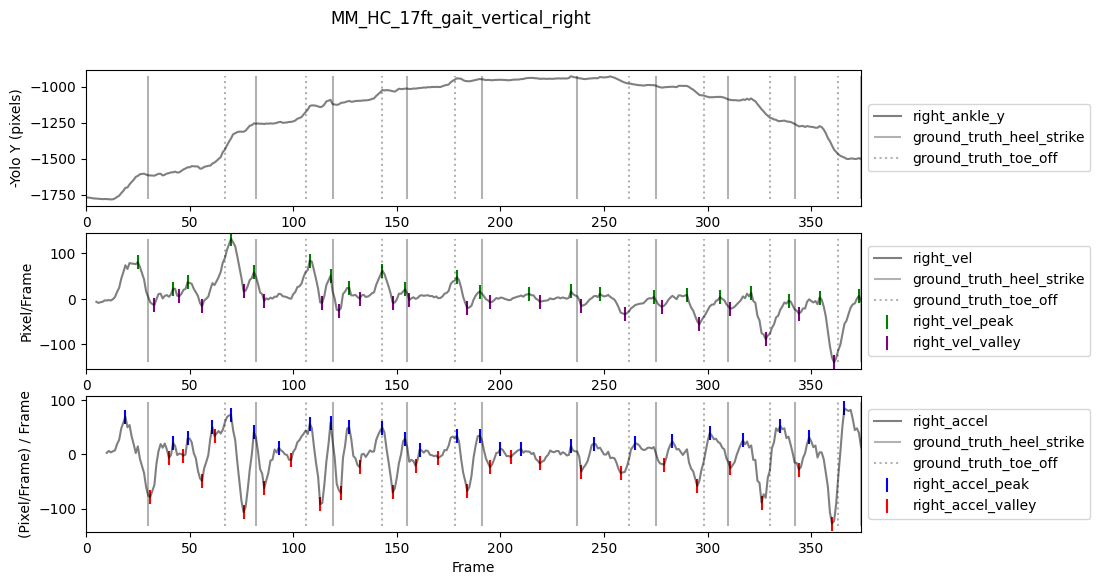

In [10]:
# plots 
# right 
import matplotlib.pyplot as plt 

# right 
fig1, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
fig1.suptitle(video_id_date_name)
ax1.plot(right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'], color = 'black', alpha = 0.5, label = 'right_ankle_y')
ax1.vlines(x = r_heel_strike_frames, ymax = r_y_max, ymin = r_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax1.vlines(x = r_toe_off_frames, ymax = r_y_max, ymin = r_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax1.set_ylabel('-Yolo Y (pixels)')
ax1.set_xlabel('Frame')
ax1.set_xlim(0, x_max)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Diff 1 - velocity 
ax2.plot(right_ank_y_data[0]['diff1_vel'], color = 'black', alpha = 0.5, label = 'right_vel')
ax2.vlines(x = r_heel_strike_frames, ymax = r_grad_max, ymin = r_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax2.vlines(x = r_toe_off_frames, ymax = r_grad_max, ymin = r_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax2.scatter(right_ank_y_data[1]['frame'], 
            right_ank_y_data[1]['diff1_vel'], 
            color = 'green',  
            marker = "|", 
            s = 100,
            label = 'right_vel_peak')
ax2.scatter(right_ank_y_data[2]['frame'], 
            right_ank_y_data[2]['diff1_vel'], 
            color = 'purple', 
            marker = "|",
            s = 100,
            label = 'right_vel_valley')
ax2.set_ylabel('Pixel/Frame')
ax2.set_xlabel('Frame')
ax2.set_xlim(0, x_max)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# gradient 2 
ax3.plot(right_ank_y_data[0]['diff2_accel'], color = 'black', alpha = 0.5, label = 'right_accel')
ax3.vlines(x = r_heel_strike_frames, ymax = r_grad2_max, ymin = r_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax3.vlines(x = r_toe_off_frames, ymax = r_grad2_max, ymin = r_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax3.scatter(right_ank_y_data[3]['frame'], 
            right_ank_y_data[3]['diff2_accel'], 
            color = 'blue',  
            marker = "|", 
            s = 100,
            label = 'right_accel_peak')
ax3.scatter(right_ank_y_data[4]['frame'], 
            right_ank_y_data[4]['diff2_accel'], 
            color = 'red', 
            marker = "|",
            s = 100,
            label = 'right_accel_valley')
ax3.set_ylabel('(Pixel/Frame) / Frame')
ax3.set_xlabel('Frame')
ax3.set_xlim(0, x_max)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save plots 
output_plot_1 = os.path.normpath(os.path.join(dir_out_prefix, (video_id_date_name + '_right_support.png')))
fig1.savefig(output_plot_1, bbox_inches = 'tight')

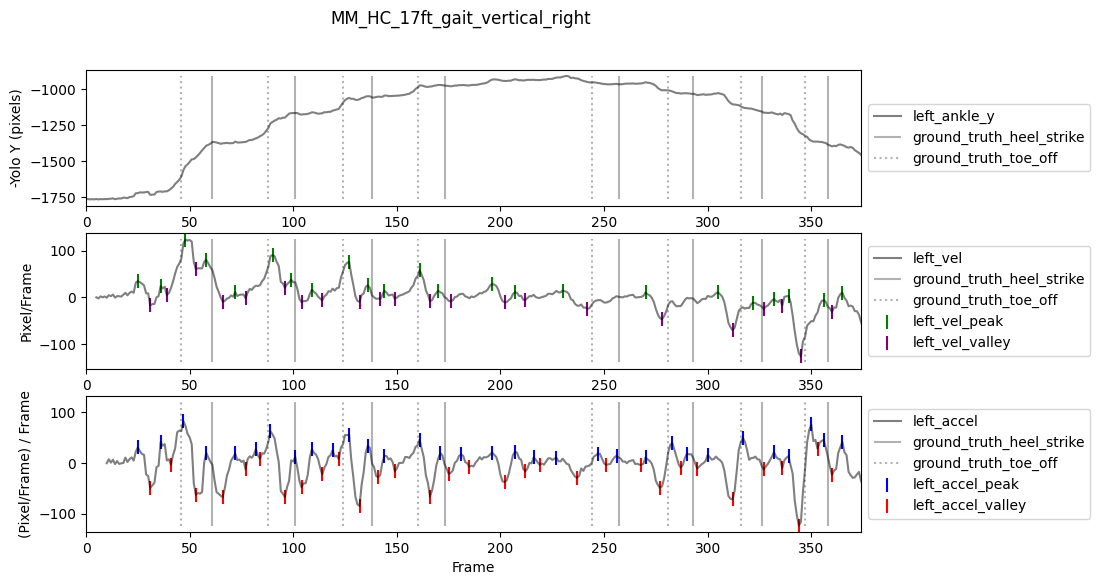

In [11]:
# fig 2 = left 
fig2, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
fig2.suptitle(video_id_date_name)
ax1.plot(left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'], color = 'black', alpha = 0.5, label = 'left_ankle_y')
ax1.vlines(x = l_heel_strike_frames, ymax = l_y_max, ymin = l_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax1.vlines(x = l_toe_off_frames, ymax = l_y_max, ymin = l_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax1.set_ylabel('-Yolo Y (pixels)')
ax1.set_xlabel('Frame')
ax1.set_xlim(0, x_max)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# gradient 1 
ax2.plot(left_ank_y_data[0]['diff1_vel'], color = 'black', alpha = 0.5, label = 'left_vel')
ax2.vlines(x = l_heel_strike_frames, ymax = l_grad_max, ymin = l_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax2.vlines(x = l_toe_off_frames, ymax = l_grad_max, ymin = l_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax2.scatter(left_ank_y_data[1]['frame'], 
            left_ank_y_data[1]['diff1_vel'], 
            color = 'green', 
            marker = "|",
            s = 100,
            label = 'left_vel_peak')
ax2.scatter(left_ank_y_data[2]['frame'], 
            left_ank_y_data[2]['diff1_vel'], 
            color = 'purple',
            marker = "|",
            s = 100,
            label = 'left_vel_valley')
ax2.set_ylabel('Pixel/Frame')
ax2.set_xlabel('Frame')
ax2.set_xlim(0, x_max)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# gradient 2
ax3.plot(left_ank_y_data[0]['diff2_accel'], color = 'black', alpha = 0.5, label = 'left_accel')
ax3.vlines(x = l_heel_strike_frames, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax3.vlines(x = l_toe_off_frames, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax3.scatter(left_ank_y_data[3]['frame'], 
            left_ank_y_data[3]['diff2_accel'], 
            color = 'blue',  
            marker = "|", 
            s = 100,
            label = 'left_accel_peak')
ax3.scatter(left_ank_y_data[4]['frame'], 
            left_ank_y_data[4]['diff2_accel'], 
            color = 'red', 
            marker = "|",
            s = 100,
            label = 'left_accel_valley')
ax3.set_ylabel('(Pixel/Frame) / Frame')
ax3.set_xlabel('Frame')
ax3.set_xlim(0, x_max)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))


output_plot_2 = os.path.normpath(os.path.join(dir_out_prefix, (video_id_date_name + '_left_support.png')))
fig2.savefig(output_plot_2, bbox_inches = 'tight')

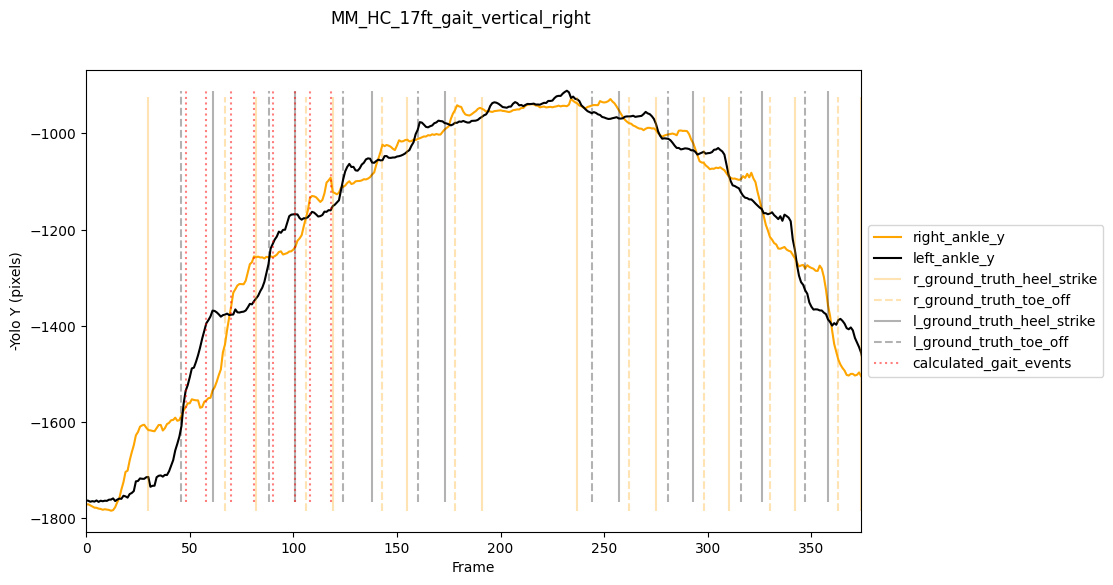

In [96]:
# plot calculated and true toe off and heel strike 
fig3, ax1 = plt.subplots(figsize=(10, 6))
fig3.suptitle(video_id_date_name)
ax1.plot(right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'], color = 'orange', alpha = 1, label = 'right_ankle_y')
ax1.plot(left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'], color = 'black', alpha = 1, label = 'left_ankle_y')

ax1.vlines(x = r_heel_strike_frames, ymax = r_y_max, ymin = r_y_min,  
           color = 'orange',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'r_ground_truth_heel_strike')
ax1.vlines(x = r_toe_off_frames, ymax = r_y_max, ymin = r_y_min, 
           color = 'orange',
           alpha = 0.3, 
           linestyle = 'dashed', 
           label = 'r_ground_truth_toe_off')

ax1.vlines(x = l_heel_strike_frames, ymax = l_y_max, ymin = l_y_min,  
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'l_ground_truth_heel_strike')
ax1.vlines(x = l_toe_off_frames, ymax = l_y_max, ymin = l_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dashed', 
           label = 'l_ground_truth_toe_off')

ax1.vlines(x = gait_events_df['frame'], ymax = l_y_max, ymin = l_y_min, 
           color = 'red',
           alpha = 0.5, 
           linestyle = 'dotted', 
           label = 'calculated_gait_events')


ax1.set_ylabel('-Yolo Y (pixels)')
ax1.set_xlabel('Frame')
ax1.set_xlim(0, x_max)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#output_plot_3 = os.path.normpath(os.path.join(dir_out_prefix, (video_id_date_name + '_calc_vs_ground_truth_gait_events.png')))
#fig3.savefig(output_plot_3, bbox_inches = 'tight')